In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
sns.set_style('whitegrid')
viridis = lambda x: matplotlib.cm.get_cmap('viridis')(x)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [5]:
from sklearn_porter import Porter

## 1. Analýza dát

In [6]:
df = pd.read_csv('train.csv', parse_dates=['Date']).set_index('Date')

In [7]:
print('Labels count = '+str(df['Label'].value_counts().sum())+':')
df['Label'].value_counts()


Labels count = 5247:


2    3246
0    1311
1     690
Name: Label, dtype: int64

In [8]:
print('data sample:')
df.sample(1)

data sample:


,Label,Alpha,Beta,Gamma,Delta,Theta
Date,,,,,,
32:48.1,0,6.993395,1.239557,-1.743477,-0.783241,7.974503


In [9]:
print('Feature means by label:')
df.groupby('Label').mean()

Feature means by label:


,Alpha,Beta,Gamma,Delta,Theta
Label,,,,,
0,10.697966,4.557121,1.971904,1.802673,10.180265
1,3.822989,1.482477,-1.116319,-1.255681,7.175921
2,5.917053,3.257057,0.765227,1.060584,8.963430


In [10]:
print('Basic statistics:')
df.describe().round(3)

Basic statistics:


,Label,Alpha,Beta,Gamma,Delta,Theta
count,5247.000,5247.000,5247.000,5247.000,5247.000,5247.000
mean,1.369,6.836,3.349,0.819,0.941,9.032
std,0.856,3.066,1.734,1.891,2.835,2.215
min,0.000,-1.094,-2.143,-4.378,-8.660,0.956
25%,1.000,4.588,2.174,-0.457,-0.950,7.579
50%,2.000,6.273,3.320,0.828,0.994,9.014
75%,2.000,8.837,4.402,2.110,2.928,10.573
max,2.000,17.018,9.400,8.008,12.167,15.466


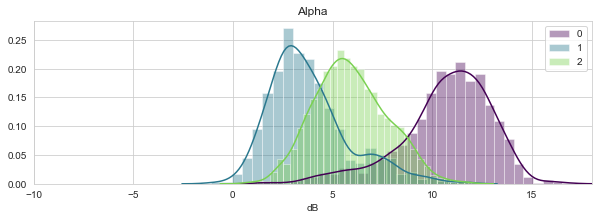

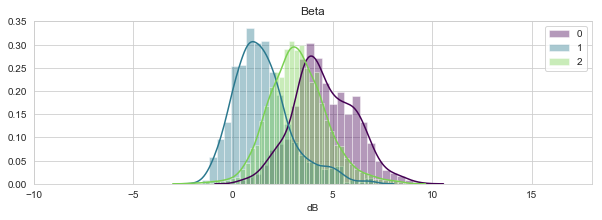

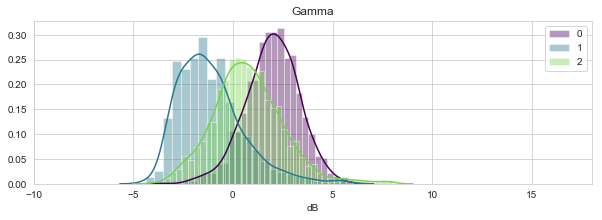

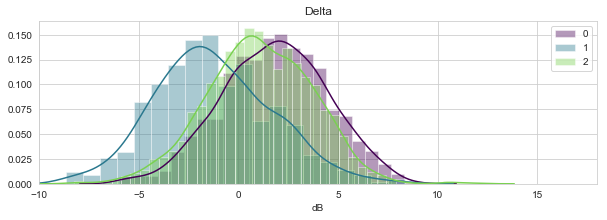

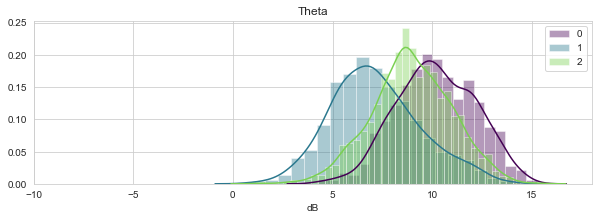

In [11]:
for col in df.columns[1:]:
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.set_title(col.capitalize())
    ax.set_xlim((-10, 18))
    ax.set_xlabel('dB')
    group = df.groupby('Label')[col].apply(list)
    
    for i in group.index:
        sns.distplot(group[i], color=viridis(i*0.4), ax=ax, label=i)
    plt.legend()

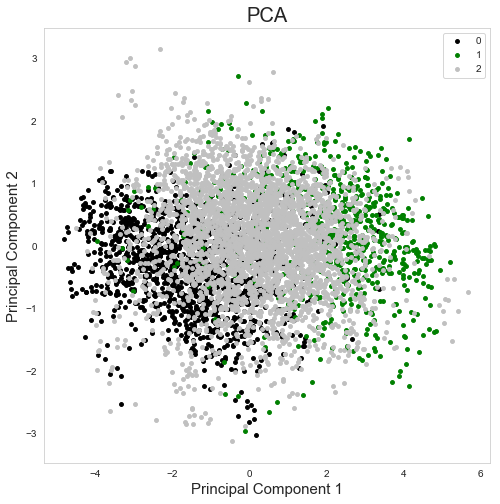

In [12]:
#načítanie dát, rozdelené podľa dátumu, index od 0
dfa = pd.read_csv('train.csv', parse_dates=['Date'])

#Rozdelenie dát na features a labels
features = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Theta']
x = dfa.loc[:, features].values
y = dfa.loc[:,['Label']].values

#škálovanie dát
x = StandardScaler().fit_transform(x)

#vytvorenie 2-rozmerného grafu z piatich rozmerov (features)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

# datagram škálovaných dát z PCA
finalDf = pd.concat([principalDf, dfa['Label']], axis = 1)

#graf kde sú farebne odlíšené dáta pre jednotlivé triedy (labels)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['black', 'green', 'silver']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 15)
ax.legend(targets)
ax.grid()

In [13]:
print(pca.explained_variance_ratio_)

[0.69122026 0.14869451]


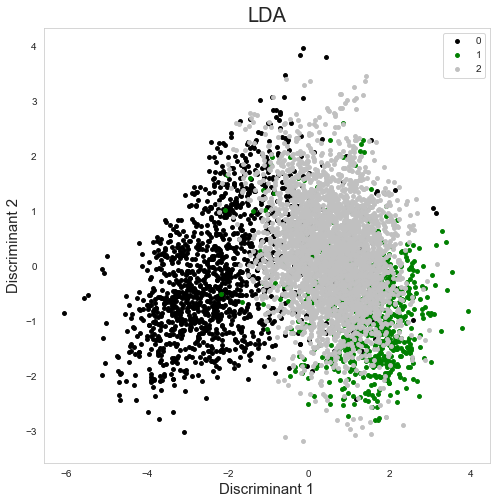

In [14]:
#Rozdelenie dát na features a labels
features = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Theta']
X = dfa.loc[:, features].values
y = dfa.loc[:,['Label']].values

#škálovanie dát
X = StandardScaler().fit_transform(X)

#vytvorenie 2-rozmerného grafu z piatich rozmerov (features)
lda = LDA(n_components=2)
linearDiscriminants = lda.fit_transform(X, y)
linearDf = pd.DataFrame(data = linearDiscriminants
             , columns = ['Linear Discriminant 1', 'Linear Discriminant 2'])

# datagram škálovaných dát z LDA
finalLinearDf = pd.concat([linearDf, dfa['Label']], axis = 1)

#graf kde sú farebne odlíšené dáta pre jednotlivé triedy (labels)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Discriminant 1', fontsize = 15)
ax.set_ylabel('Discriminant 2', fontsize = 15)
ax.set_title('LDA', fontsize = 20)
targets = [0, 1, 2]
colors = ['black', 'green', 'silver']

for target, color in zip(targets,colors):
    indicesToKeep = finalLinearDf['Label'] == target
    ax.scatter(finalLinearDf.loc[indicesToKeep, 'Linear Discriminant 1']
               , finalLinearDf.loc[indicesToKeep, 'Linear Discriminant 2']
               , c = color
               , s = 15)
ax.legend(targets)
ax.grid()

## 2. Modelovanie dát

In [15]:
def train(df, estimator):
    X = df.drop('Label', 1)
    y = df['Label']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
    estimator.fit(X_train, y_train)
    
    pred_train = estimator.predict(X_train)
    pred_test = estimator.predict(X_test)

    error_train = 1 - accuracy_score(y_train, pred_train)
    error_test = 1 - accuracy_score(y_test, pred_test)
    
    accuracy_train = 100*accuracy_score(y_train, pred_train)
    accuracy_test = 100*accuracy_score(y_test, pred_test)
    
    return accuracy_train, accuracy_test, error_train, error_test

def Model_results(df, estimators):
    results = pd.DataFrame(index=['train_accuracy', 'test_accuracy','train_error', 'test_error', ])
    for estimator in estimators:
        name = str(estimator).split('(')[0]
        results[name] = train(df, estimator)
    return results.transpose()

In [16]:
estimators = [
    SVC(kernel='rbf', C=1.0, gamma='auto'),
    KNeighborsClassifier(7), 
    RandomForestClassifier(30), 
    ExtraTreesClassifier(30),
    MLPClassifier()
]

### Vytváranie modelov pôvodných dát

In [17]:
# Trénovanie modelov na pôvodných dátach.
Model_results(df, estimators)

,train_accuracy,test_accuracy,train_error,test_error
SVC,86.990708,85.809524,0.130093,0.141905
KNeighborsClassifier,86.752442,84.857143,0.132476,0.151429
RandomForestClassifier,99.880867,84.952381,0.001191,0.150476
ExtraTreesClassifier,100.000000,86.380952,0.000000,0.136190
MLPClassifier,85.013105,83.809524,0.149869,0.161905


### vytváranie modelov s dátami z PCA

In [18]:
#Trénovanie modelov s dátami z PCA.
Model_results(finalDf, estimators)

,train_accuracy,test_accuracy,train_error,test_error
SVC,73.600191,73.809524,0.263998,0.261905
KNeighborsClassifier,77.507744,70.476190,0.224923,0.295238
RandomForestClassifier,99.809388,68.761905,0.001906,0.312381
ExtraTreesClassifier,100.000000,67.809524,0.000000,0.321905
MLPClassifier,73.457231,73.714286,0.265428,0.262857


### vytváranie modelov s dátami z LDA

In [19]:
#Trénovanie modelov s dátami z LDA.
Model_results(finalLinearDf, estimators)

,train_accuracy,test_accuracy,train_error,test_error
SVC,83.678818,84.285714,0.163212,0.157143
KNeighborsClassifier,85.084584,82.952381,0.149154,0.170476
RandomForestClassifier,99.785561,83.047619,0.002144,0.169524
ExtraTreesClassifier,100.000000,81.714286,0.000000,0.182857
MLPClassifier,83.678818,84.857143,0.163212,0.151429


## 3. Konverzia modelov pôvodných dát do Javy

In [20]:
def trainModel(df, estimator):
    train(df, estimator)
    return estimator

In [21]:
for estimator in estimators:
    porter = Porter(trainModel(df, estimator), language='java')
    output = porter.export(embed_data=True)

    name = str(estimator).split('(')[0]
    with open(name + '.java', 'w') as out:
       out.write(output)